In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from scipy import signal
from scipy.interpolate import griddata

import sys
sys.path.append("/home/j/j_mens07/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets_utils
import nanonets
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

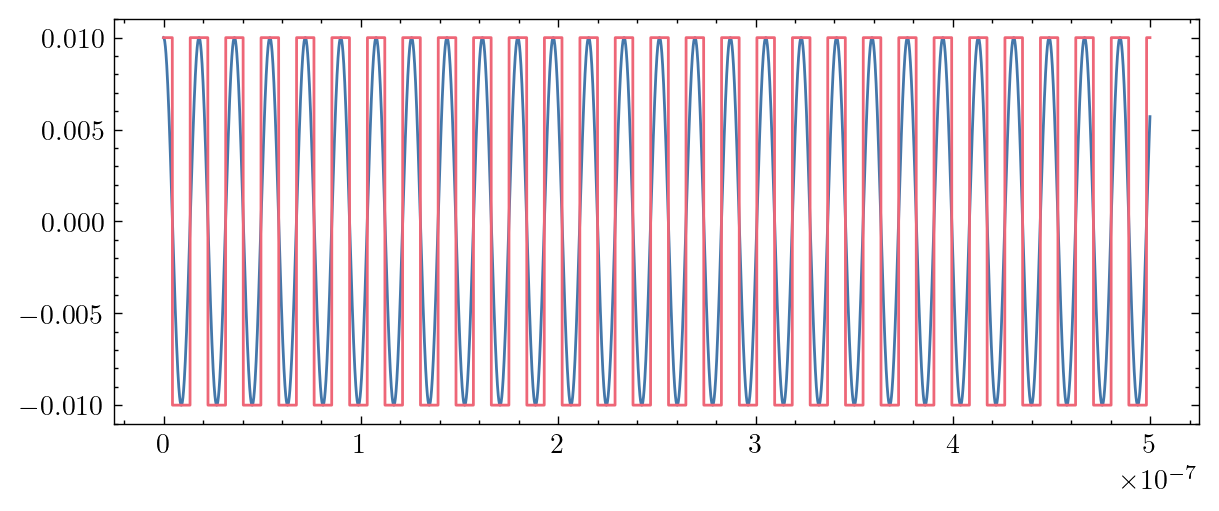

In [2]:
amplitude   = 0.01
freq        = 3.5
time_step   = 1e-10
N_periods   = 50
N_voltages  = 5000
time_steps  = time_step*np.arange(N_voltages)
x_vals      = amplitude*np.cos(freq*time_steps*1e8)
y_target    = amplitude*signal.square(freq*time_steps*1e8-3*np.pi/2)
x_scaled    = (x_vals-np.mean(x_vals))/np.std(x_vals)
y_scaled    = (y_target-np.mean(y_target))/np.std(y_target)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(time_steps, x_vals)
    ax.plot(time_steps, y_target)

In [ ]:
time_steps  = time_step*np.arange(N_voltages)

In [15]:
results = pd.DataFrame()
errors  = pd.DataFrame()
n_vals  = 4000
t_step  = 1e-10
times   = t_step*np.arange(N_voltages)*1e9
s_type  = 'amplitude'
volt    = []

n = 0
for i in range(10):
    for j in range(50):
        df_tmp              = pd.read_csv(f"../data/lhs_sample_noise/{s_type}/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        results.loc[:,n]    = df_tmp.iloc[:,-2].reset_index(drop=True)
        errors.loc[:,n]     = df_tmp.iloc[:,-1].reset_index(drop=True)
        n                   = n + 1
        volt.append(df_tmp.iloc[:,1:7])

results_norm    = (results.iloc[-n_vals:,:]-results.iloc[-n_vals:,:].mean())/results.iloc[-n_vals,:].std()
results_norm    = 2*(results_norm - results_norm.min())/(results_norm.max()-results_norm.min())-1
results_norm    = results_norm.round(4).reset_index(drop=True)
mse             = np.sqrt(np.mean((results_norm - y_scaled[-n_vals:,np.newaxis])**2, axis=0))
min_val         = np.argmin(mse)

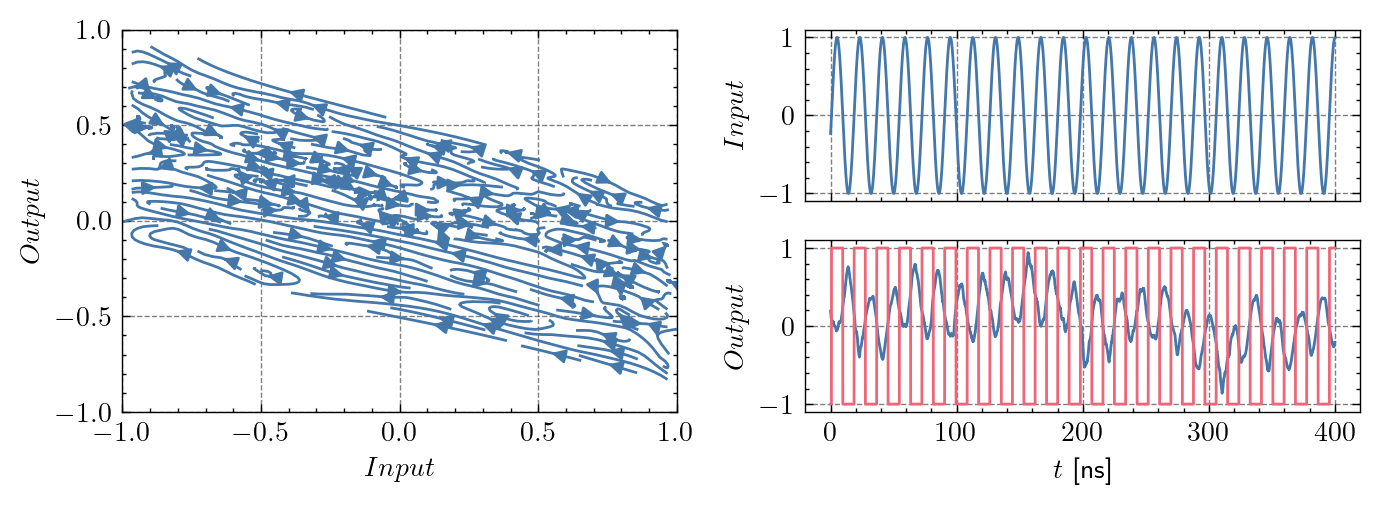

In [17]:
t       = time_steps[:n_vals]*1e9
x       = x_scaled[-n_vals:]
x       = 2*(x - np.min(x))/(np.max(x)-np.min(x)) - 1
y       = signal.savgol_filter(results_norm[min_val], window_length=31, polyorder=3)
# y       = results_norm[min_val]
y_t     = y_scaled[-n_vals:]

dx_dt   = np.gradient(x, t)
dy_dt   = np.gradient(y, t)
X, Y    = np.meshgrid(np.linspace(np.min(x), np.max(x), 100),
                      np.linspace(np.min(y), np.max(y), 100))
points = np.array([x, y]).T

U = griddata(points, dx_dt, (X, Y), method='linear')
V = griddata(points, dy_dt, (X, Y), method='linear')
U = np.ma.masked_invalid(U)
V = np.ma.masked_invalid(V)

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax.streamplot(X, Y, U, V, density=2)
    # ax.streamplot(X, Y, U, V, density=2, start_points=[[0,0]])
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("$Input$")
    ax.set_ylabel("$Output$")

    ax  = fig.add_subplot(2,2,2)
    ax.plot(t, x)
    ax.set_ylabel("$Input$")
    ax.set_xticklabels("")
    # ax.set_xlim(0,100)

    ax  = fig.add_subplot(2,2,4)
    ax.plot(t, y)
    ax.plot(t, y_t)
    ax.set_ylabel("$Output$")
    ax.set_xlabel("$t$ [ns]")
    # ax.set_xlim(0,100)

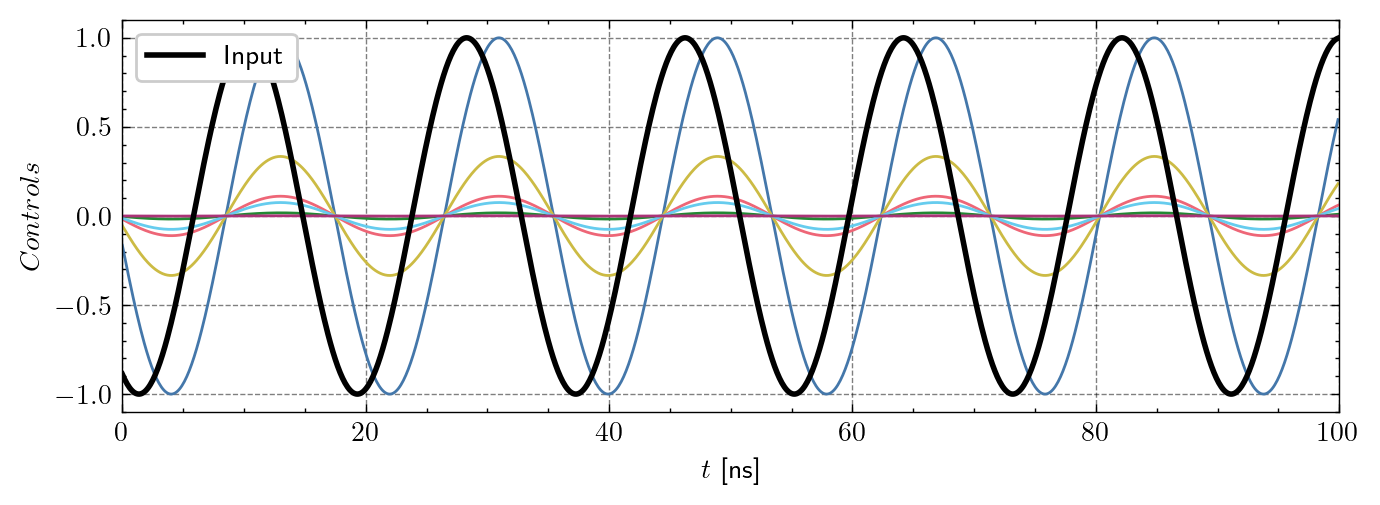

In [13]:
v = volt[min_val].iloc[-n_vals:,:].reset_index(drop=True)*1000
v = 2*(v - np.min(v))/(np.max(v)-np.min(v)) - 1

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(t, v)
    ax.plot(t, x, 'black', label='Input', lw=2)
    ax.set_ylabel("$Controls$")
    ax.set_xlabel("$t$ [ns]")
    ax.set_xlim(0,100)
    ax.legend(loc='upper left')

---

### States

In [52]:
def shannon_rank(state : np.array):

    U, S, Vt    = np.linalg.svd(state)
    p           = S / np.sum(S)
    rank        = np.exp(-np.sum(p*np.log(p)))

    return rank

In [174]:
N_p                 = 7
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                           [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],[0,N_p-1,0],
                           [N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
}
sim_class   = nanonets.simulation(topology_parameter=topology_parameter, seed=0)
cap_inv     = sim_class.inv_capacitance_matrix

In [439]:
results         = []
results_states  = []

n_vals  = 1000
s_types = ["const","amplitude","offset","phase","frequency"]

for s_type in s_types:

    states  = []
    volt    = []
    ranks   = []

    for i in range(10):
        for j in range(50):
            df_tmp  = pd.read_csv(f"../data/lhs_sample_noise/{s_type}/mean_state_Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
            state   = 1000*df_tmp.iloc[-n_vals:,:].reset_index(drop=True).values @ cap_inv
            states.append(state)
            ranks.append(shannon_rank(state))
            volt.append(df_tmp.iloc[-n_vals:,0:7])

    results.append(ranks)
    results_states.append(states)

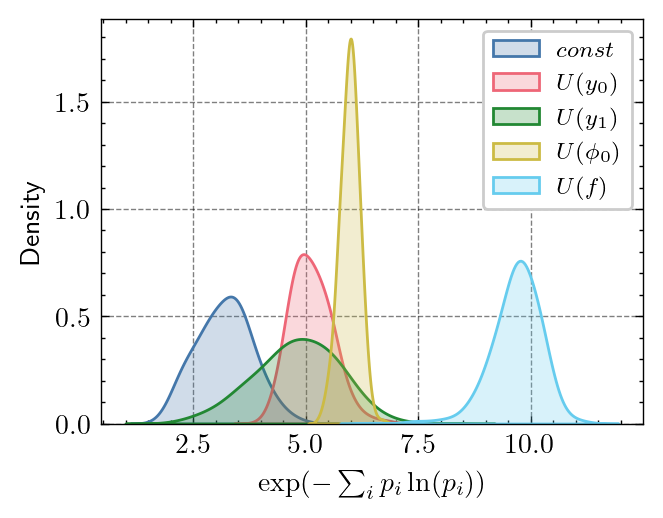

In [440]:
with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for vals in results:
        ax  = sns.kdeplot(vals, ax=ax, fill=True, cut=3, bw_adjust=1.5)
        
    ax.legend(['$const$','$U(y_0)$','$U(y_1)$','$U(\phi_0)$','$U(f)$'], fontsize='small')
    # ax.set_xlim(4,12)
    ax.set_xlabel("$\exp(-\sum_i p_i \ln(p_i))$")

In [441]:
def multiplot_observable_based_on_network(x_vals : pd.DataFrame, y_vals : pd.DataFrame, N : int,
                                          fig_scale=(1.5,1.5), x_lim=None, y_lim=None, y_label='y',
                                          x_label='x', log_x=False, log_y=False, style_context=["science","bright","grid"],
                                          x_full_range=False, y_full_range=False):
    
    if type(x_vals) == type(np.array([])):

        x_vals_new = pd.DataFrame()

        for col in y_vals.columns:

            x_vals_new[col] = x_vals
    
        x_vals = x_vals_new

    with plt.style.context(style_context):
        
        fig, axs    = plt.subplots(ncols=N, nrows=N, layout='constrained')
        width       = fig.get_figwidth()
        fig.set_figwidth(width*fig_scale[0])
        fig.set_figheight(width*fig_scale[1])

        if x_lim == None:
            x_lim = [x_vals.min().min(), x_vals.max().max()]

        if y_lim == None:
            y_lim = [y_vals.min().min(), y_vals.max().max()]

        i = 0

        for row in np.arange((N-1),-1,-1):
            
            for col in range(0,N):

                axs[row,col].plot(x_vals.loc[:,i], y_vals.loc[:,i])
                
                axs[row,col].set_xlim(x_lim[0],x_lim[1])
                axs[row,col].set_ylim(y_lim[0],y_lim[1])

                if i % N != 0:
                    axs[row,col].set_yticklabels("")
                else:    
                    axs[row,col].set_ylabel(y_label)

                if (i > N-1):
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel(x_label)

                if log_x:
                    axs[row,col].set_xscale('log')

                if log_y:
                    axs[row,col].set_yscale('log')

                if y_full_range:
                    axs[row,col].set_ylim(y_vals.loc[:,i].min(),y_vals.loc[:,i].max())
                    axs[row,col].set_yticklabels("")

                if x_full_range:
                    axs[row,col].set_xlim(x_vals.loc[:,i].min(),x_vals.loc[:,i].max())
                    axs[row,col].set_xticklabels("")

                i += 1

    return fig, axs

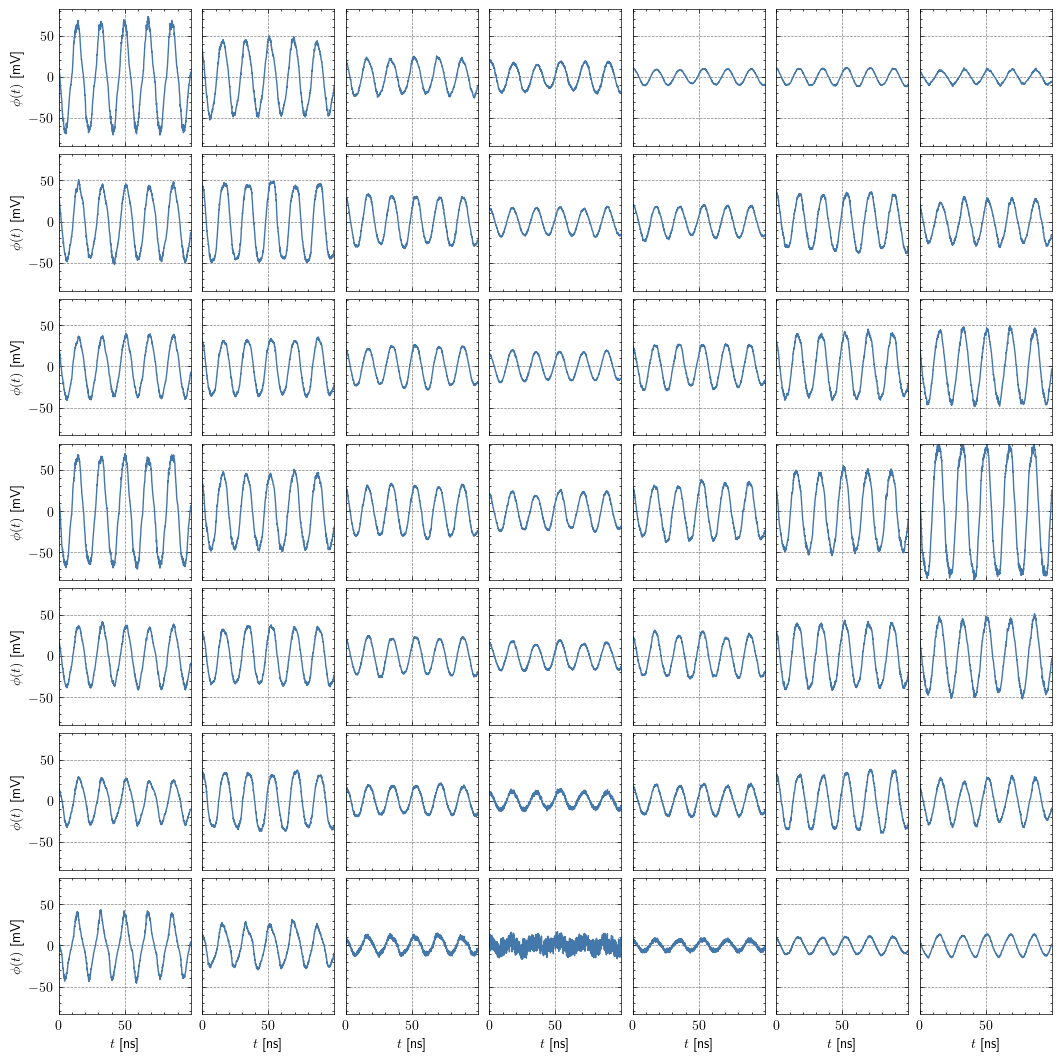

In [450]:
n           = 1
vals        = pd.DataFrame(results_states[n][np.argmax(results[n])])
x_vals      = np.arange(n_vals)*1e-10*1e9
fig, axs    = multiplot_observable_based_on_network(x_vals, vals, 7, fig_scale=(3,3), x_label="$t$ [ns]", y_label='$\phi(t)$ [mV]', y_full_range=False)

MovieWriter ffmpeg unavailable; using Pillow instead.


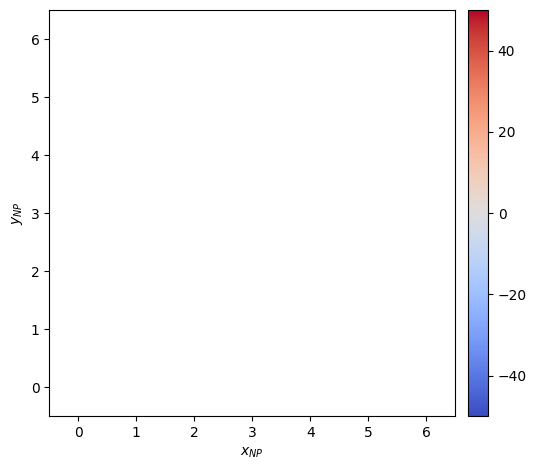

In [451]:
ani = nanonets_utils.animate_landscape(vals.values, N_p, N_p, vmin=-50, vmax=50, interpolation='bicubic', delay_between_frames=10)
ani.save('test.gif')

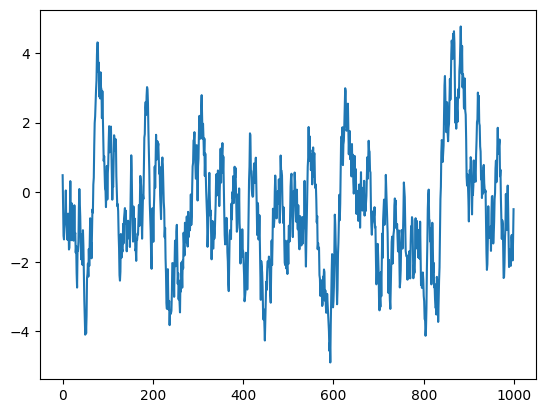

In [438]:
noise   = np.random.uniform(-1,1,n_vals)
vals    = np.zeros(len(noise))
vals[0] = noise[0]

for i in range(1, len(noise)):

    vals[i] = 0.95*vals[i-1] + noise[i]

plt.plot(vals)